# Post-Training Quantization: Deployment Comparison

This notebook simulates the **standard ML deployment workflow**:

1. **Train** both models in **FP32** (full precision) — for maximum training stability
2. **Quantize** both to **FP16** — for efficient deployment
3. **Compare** the quantized versions — what actually gets deployed

## Motivation

In production ML pipelines:
- **Training**: FP32 ensures numerical stability and reproducibility
- **Deployment**: FP16 reduces memory footprint and enables tensor core acceleration

This comparison answers: **When both models are quantized for deployment, which architecture performs better?**

The key question: Does the recurrent architecture's weight sharing make it more or less sensitive to quantization?


In [ ]:
import torch
import torch.nn as nn
import torch.quantization as quant
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Add project root to path

from models.baseline import BaselineModel, BaselineConfig
from models.recurrent import RecurrentModel, RecurrentConfig
from training.utils.data_loader import prepare_sst2_data, load_tokenizer
from evaluation.eval import ModelEvaluator, compute_model_metrics

# Set device - use GPU for all models (FP32 and FP16)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    # Check FP16 support
    if torch.cuda.get_device_capability(0)[0] >= 7:
        print("Tensor Cores available for FP16 acceleration!")


Using device: cuda
PyTorch version: 2.9.0+cu126
GPU: NVIDIA L4
CUDA version: 12.6
Tensor Cores available for FP16 acceleration!


## Model Configurations

Using the same configurations as in the main experiments.


In [ ]:
# =========================
# Baseline Transformer (384)
# =========================
BASELINE_CONFIG = BaselineConfig(
    vocab_size=30522,
    hidden_size=384,
    num_hidden_layers=6,
    num_attention_heads=6,
    intermediate_size=1536,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    max_position_embeddings=128,
    num_labels=2,
    use_flash_attention=True,
    use_swiglu=True,
    use_rope=True,
    use_rms_norm=True
)

# =========================
# Recurrent Transformer (384)
# Same width as baseline for fair quantization comparison
# =========================
RECURRENT_CONFIG = RecurrentConfig(
    vocab_size=30522,
    hidden_size=384,
    num_hidden_layers=3,      # Shared layers
    recurrent_depth=2,        # 3 × 2 = 6
    num_attention_heads=6,
    intermediate_size=1536,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    max_position_embeddings=128,
    num_labels=2,
    residual_scale=0.5,
    use_flash_attention=True,
    use_swiglu=True,
    use_rope=True,
    use_rms_norm=True
)

# =========================
# Light Recurrent Transformer (256)
# Lighter, smaller memory, good for quantization stress test
# =========================
LIGHT_RECURRENT_CONFIG = RecurrentConfig(
    vocab_size=30522,
    hidden_size=256,           # ↓ narrower width
    num_hidden_layers=3,
    recurrent_depth=2,         # Still 6 effective depth
    num_attention_heads=4,     # ↓ fewer heads
    intermediate_size=1024,    # ↓ smaller FFN
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    max_position_embeddings=128,
    num_labels=2,
    residual_scale=0.5,
    use_flash_attention=True,
    use_swiglu=True,
    use_rope=True,
    use_rms_norm=True
)

print("All 3 model configurations loaded!")


All 3 model configurations loaded!


In [ ]:
from training import train_model

# Training configuration
TRAINING_CONFIG = {
    'num_epochs': 5,
    'batch_size': 16,
    'learning_rate': 3e-5,
    'warmup_steps': 100,
    'eval_steps': 50,
    'max_length': 128
}

## Load SST-2 Data


In [ ]:
# Load tokenizer and data
# Load data
from training.utils import prepare_sst2_data, load_tokenizer

tokenizer = load_tokenizer('bert-base-uncased')
train_loader, val_loader, test_loader = prepare_sst2_data(
    data_dir='data/processed',
    tokenizer=tokenizer,
    batch_size=TRAINING_CONFIG['batch_size'],
    max_length=TRAINING_CONFIG['max_length']
)

train_size = len(train_loader) * TRAINING_CONFIG['batch_size']
val_size = len(val_loader) * TRAINING_CONFIG['batch_size']
print(f"Dataset sizes - Train: {train_size}, Validation: {val_size}")



Loaded 54576 samples from data/processed/sst2_train.pkl
Loaded 6822 samples from data/processed/sst2_val.pkl
Loaded 6823 samples from data/processed/sst2_test.pkl
Dataset sizes - Train: 54576, Validation: 6832


## Step 1: Initialize and Train Models (FP32)

Train both models in FP32 for 5 epochs with early stopping, then use trained weights for quantization comparison.


In [ ]:
# ============================
# Initialize models (FP32)
# ============================
baseline_model = BaselineModel(BASELINE_CONFIG).to(device)
recurrent_model = RecurrentModel(RECURRENT_CONFIG).to(device)
light_recurrent_model = RecurrentModel(LIGHT_RECURRENT_CONFIG).to(device)

# ============================
# Utility functions
# ============================
def get_model_size(model):
    """Return model size in MB"""
    param_size = sum(p.nelement() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.nelement() * b.element_size() for b in model.buffers())
    return (param_size + buffer_size) / 1024 / 1024

def count_parameters(model):
    """Count total model parameters"""
    return sum(p.numel() for p in model.parameters())

def print_model_stats(name, model):
    """Pretty print statistics for a model"""
    print(f"\n=== {name} ===")
    print(f"  Parameters : {count_parameters(model):,}")
    print(f"  Size (MB)  : {get_model_size(model):.2f}")

# ============================
# Print all three
# ============================
print_model_stats("Baseline Transformer (384)", baseline_model)
print_model_stats("Recurrent Transformer (384)", recurrent_model)
print_model_stats("Light Recurrent (256)", light_recurrent_model)

print("\nModel initialization complete.")


=== Baseline Transformer (384) ===
  Parameters : 25,912,706
  Size (MB)  : 98.85

=== Recurrent Transformer (384) ===
  Parameters : 18,817,538
  Size (MB)  : 71.78

=== Light Recurrent (256) ===
  Parameters : 10,972,162
  Size (MB)  : 41.86

Model initialization complete.


In [ ]:
# ============================================
# TRAINING PHASE (FP32)
# ============================================
print("=" * 70)
print("TRAINING PHASE: Training all models in FP32")
print("=" * 70)

# Models to train
models_to_train = {
    "baseline": baseline_model,
    "recurrent": recurrent_model,
    "light_recurrent": light_recurrent_model
}

training_histories = {}

# Loop over models
for name, model in models_to_train.items():
    print(f"\n--- Training {name.replace('_', ' ').title()} ---")

    history = train_model(
        model=model,
        name=f"sst-{name}",
        num_epochs=TRAINING_CONFIG["num_epochs"],
        patience=TRAINING_CONFIG["patience"],
        min_delta=TRAINING_CONFIG["min_delta"]
    )

    training_histories[name] = history

    # Switch to eval mode after training
    model.eval()

# ============================================
# Training Complete Summary
# ============================================
print("\n" + "=" * 70)
print("All model training completed successfully!")
print("=" * 70)


TRAINING PHASE: Training all models in FP32

--- Training Baseline ---

===== Training sst-baseline (FP16=False) =====


sst-baseline Epoch 1: train=0.4298, val=0.3290, acc=0.8569 → NEW BEST


sst-baseline Epoch 2: train=0.2635, val=0.3078, acc=0.8984 → NEW BEST


sst-baseline Epoch 3: train=0.2202, val=0.2768, acc=0.9008 → NEW BEST


sst-baseline Epoch 4: train=0.1905, val=0.2752, acc=0.9096 → NEW BEST


sst-baseline Epoch 5: train=0.1642, val=0.3455, acc=0.9151
sst-baseline: Loaded best model from epoch=4, val_loss=0.2752

--- Training Recurrent ---

===== Training sst-recurrent (FP16=False) =====


sst-recurrent Epoch 1: train=0.4333, val=0.3204, acc=0.8851 → NEW BEST


sst-recurrent Epoch 2: train=0.2638, val=0.2621, acc=0.9025 → NEW BEST


sst-recurrent Epoch 3: train=0.2171, val=0.2964, acc=0.9003


sst-recurrent Epoch 4: train=0.1914, val=0.3069, acc=0.9148


sst-recurrent Epoch 5: train=0.1662, val=0.3456, acc=0.9120
sst-recurrent: Early stopping at epoch 5
sst-recurrent: Loaded best model from epoch=2, val_loss=0.2621

--- Training Light Recurrent ---

===== Training sst-light_recurrent (FP16=False) =====


sst-light_recurrent Epoch 1: train=0.4471, val=0.3167, acc=0.8805 → NEW BEST


sst-light_recurrent Epoch 2: train=0.2670, val=0.2999, acc=0.8977 → NEW BEST


sst-light_recurrent Epoch 3: train=0.2216, val=0.2631, acc=0.9065 → NEW BEST


sst-light_recurrent Epoch 4: train=0.1974, val=0.2856, acc=0.9110


sst-light_recurrent Epoch 5: train=0.1771, val=0.3177, acc=0.9122
sst-light_recurrent: Loaded best model from epoch=3, val_loss=0.2631

All model training completed successfully!


## Step 2: FP16 Inference via Automatic Mixed Precision (AMP)

In production, FP16 inference is done using **AMP (Automatic Mixed Precision)**:
- Model weights stay in FP32 during development
- AMP automatically runs computations in FP16 during inference
- Handles dtype conversions between layers automatically

**Why AMP for FP16?**
- 2× smaller model when exported/deployed
- Native GPU support with tensor core acceleration
- No manual dtype management needed
- Standard practice: PyTorch AMP, TensorRT, ONNX Runtime


In [ ]:
print("=" * 70)
print("FP16 INFERENCE (AMP) – Models remain FP32, compute runs in FP16")
print("=" * 70)
print("Using torch.cuda.amp.autocast() for mixed precision inference.\n")

# Models to compare
models = {
    "Baseline Transformer (384)": baseline_model,
    "Recurrent Transformer (384)": recurrent_model,
    "Light Recurrent (256)": light_recurrent_model
}

def theoretical_fp16_size(model):
    """FP16 halves the storage of FP32 parameters."""
    return get_model_size(model) / 2

# Print table header
print(f"{'Model':35s} | {'FP32 (MB)':>10s} | {'FP16 (MB)':>10s} | {'Saving (%)':>10s}")
print("-" * 70)

# Generate comparison rows
for name, model in models.items():
    fp32_size = get_model_size(model)
    fp16_size = theoretical_fp16_size(model)
    saving = (1 - fp16_size / fp32_size) * 100

    print(f"{name:35s} | {fp32_size:10.2f} | {fp16_size:10.2f} | {saving:9.1f}%")

print("\nNote: AMP keeps weights in FP32, but compute and activations use FP16.")
print("      FP16 size above is theoretical when exporting weights as FP16.")

FP16 INFERENCE (AMP) – Models remain FP32, compute runs in FP16
Using torch.cuda.amp.autocast() for mixed precision inference.

Model                               |  FP32 (MB) |  FP16 (MB) | Saving (%)
----------------------------------------------------------------------
Baseline Transformer (384)          |      98.85 |      49.42 |      50.0%
Recurrent Transformer (384)         |      71.78 |      35.89 |      50.0%
Light Recurrent (256)               |      41.86 |      20.93 |      50.0%

Note: AMP keeps weights in FP32, but compute and activations use FP16.
      FP16 size above is theoretical when exporting weights as FP16.


In [ ]:
def evaluate_model(model, loader, use_amp=False):
    model.eval()

    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    inference_times = []

    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            # --- FP32 or FP16 (AMP) inference ---
            if use_amp:
                with torch.cuda.amp.autocast(dtype=torch.float16):
                    start = time.time()
                    outputs = model(
                        input_ids=batch['input_ids'],
                        attention_mask=batch['attention_mask']
                    )
                    elapsed = time.time() - start
            else:
                start = time.time()
                outputs = model(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask']
                )
                elapsed = time.time() - start

            inference_times.append(elapsed * 1000 / batch['input_ids'].size(0))

            preds = outputs['logits'].argmax(dim=-1)

            total_correct += (preds == batch['labels']).sum().item()
            total_samples += batch['labels'].size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    accuracy = total_correct / total_samples

    from sklearn.metrics import f1_score, precision_score, recall_score
    f1 = f1_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'inference_time_ms': np.mean(inference_times),
        'y_true': all_labels,
        'y_pred': all_preds
    }


In [ ]:
results = []

evaluation_tasks = [
    ("Baseline", baseline_model, "FP32", False),
    ("Baseline", baseline_model, "FP16", True),

    ("Recurrent", recurrent_model, "FP32", False),
    ("Recurrent", recurrent_model, "FP16", True),

    ("Light-Recurrent", light_recurrent_model, "FP32", False),
    ("Light-Recurrent", light_recurrent_model, "FP16", True),
]

for name, model, precision, use_amp in evaluation_tasks:
    print(f"\nEvaluating {name} ({precision})...")

    metrics = evaluate_model(model, test_loader, use_amp=use_amp)

    metrics["model"] = f"{name} ({precision})"   # FIXED: lowercase 'model'
    metrics["precision_type"] = precision
    metrics["parameters"] = count_parameters(model)
    metrics["size_mb"] = get_model_size(model) if precision == "FP32" else get_model_size(model)/2

    results.append(metrics)




Evaluating Baseline (FP32)...

Evaluating Baseline (FP16)...

Evaluating Recurrent (FP32)...

Evaluating Recurrent (FP16)...

Evaluating Light-Recurrent (FP32)...

Evaluating Light-Recurrent (FP16)...


In [ ]:
import pandas as pd

# Normalize inference time column
for r in results:
    if "inference_time_ms" in r and "avg_inference_ms" not in r:
        r["avg_inference_ms"] = r["inference_time_ms"]

# Convert to DataFrame
df = pd.DataFrame(results)

# Required columns (fill missing to avoid KeyError)
required_cols = [
    "model",
    "precision_type",
    "parameters",
    "size_mb",
    "accuracy",
    "f1",
    "precision",
    "recall",
    "avg_inference_ms"
]

for c in required_cols:
    if c not in df.columns:
        df[c] = None

# Final ordered DataFrame
comparison_df = df[required_cols]

# Format output
comparison_df_fmt = comparison_df.copy()
comparison_df_fmt["parameters"] = comparison_df_fmt["parameters"].apply(lambda x: f"{x:,}")
comparison_df_fmt["size_mb"] = comparison_df_fmt["size_mb"].apply(lambda x: f"{x:.2f}")
comparison_df_fmt["accuracy"] = comparison_df_fmt["accuracy"].apply(lambda x: f"{x:.4f}")
comparison_df_fmt["f1"] = comparison_df_fmt["f1"].apply(lambda x: f"{x:.4f}")
comparison_df_fmt["precision"] = comparison_df_fmt["precision"].apply(lambda x: f"{x:.4f}")
comparison_df_fmt["recall"] = comparison_df_fmt["recall"].apply(lambda x: f"{x:.4f}")
comparison_df_fmt["avg_inference_ms"] = comparison_df_fmt["avg_inference_ms"].apply(lambda x: f"{x:.3f}")

print("\n=== FINAL MODEL COMPARISON TABLE ===")
display(comparison_df_fmt)


=== FINAL MODEL COMPARISON TABLE ===


,model,precision_type,parameters,size_mb,accuracy,f1,precision,recall,avg_inference_ms
0,Baseline (FP32),FP32,"25,912,706",98.85,0.9022,0.9125,0.9036,0.9215,0.411
1,Baseline (FP16),FP16,"25,912,706",49.42,0.9021,0.9123,0.9034,0.9213,0.246
2,Recurrent (FP32),FP32,"18,817,538",71.78,0.9100,0.9182,0.9226,0.9138,0.405
3,Recurrent (FP16),FP16,"18,817,538",35.89,0.9100,0.9180,0.9221,0.9134,0.241
4,Light-Recurrent (FP32),FP32,"10,972,162",41.86,0.8977,0.9082,0.9017,0.9146,0.403
5,Light-Recurrent (FP16),FP16,"10,972,162",20.93,0.8977,0.9082,0.9017,0.9146,0.230


## Visualization


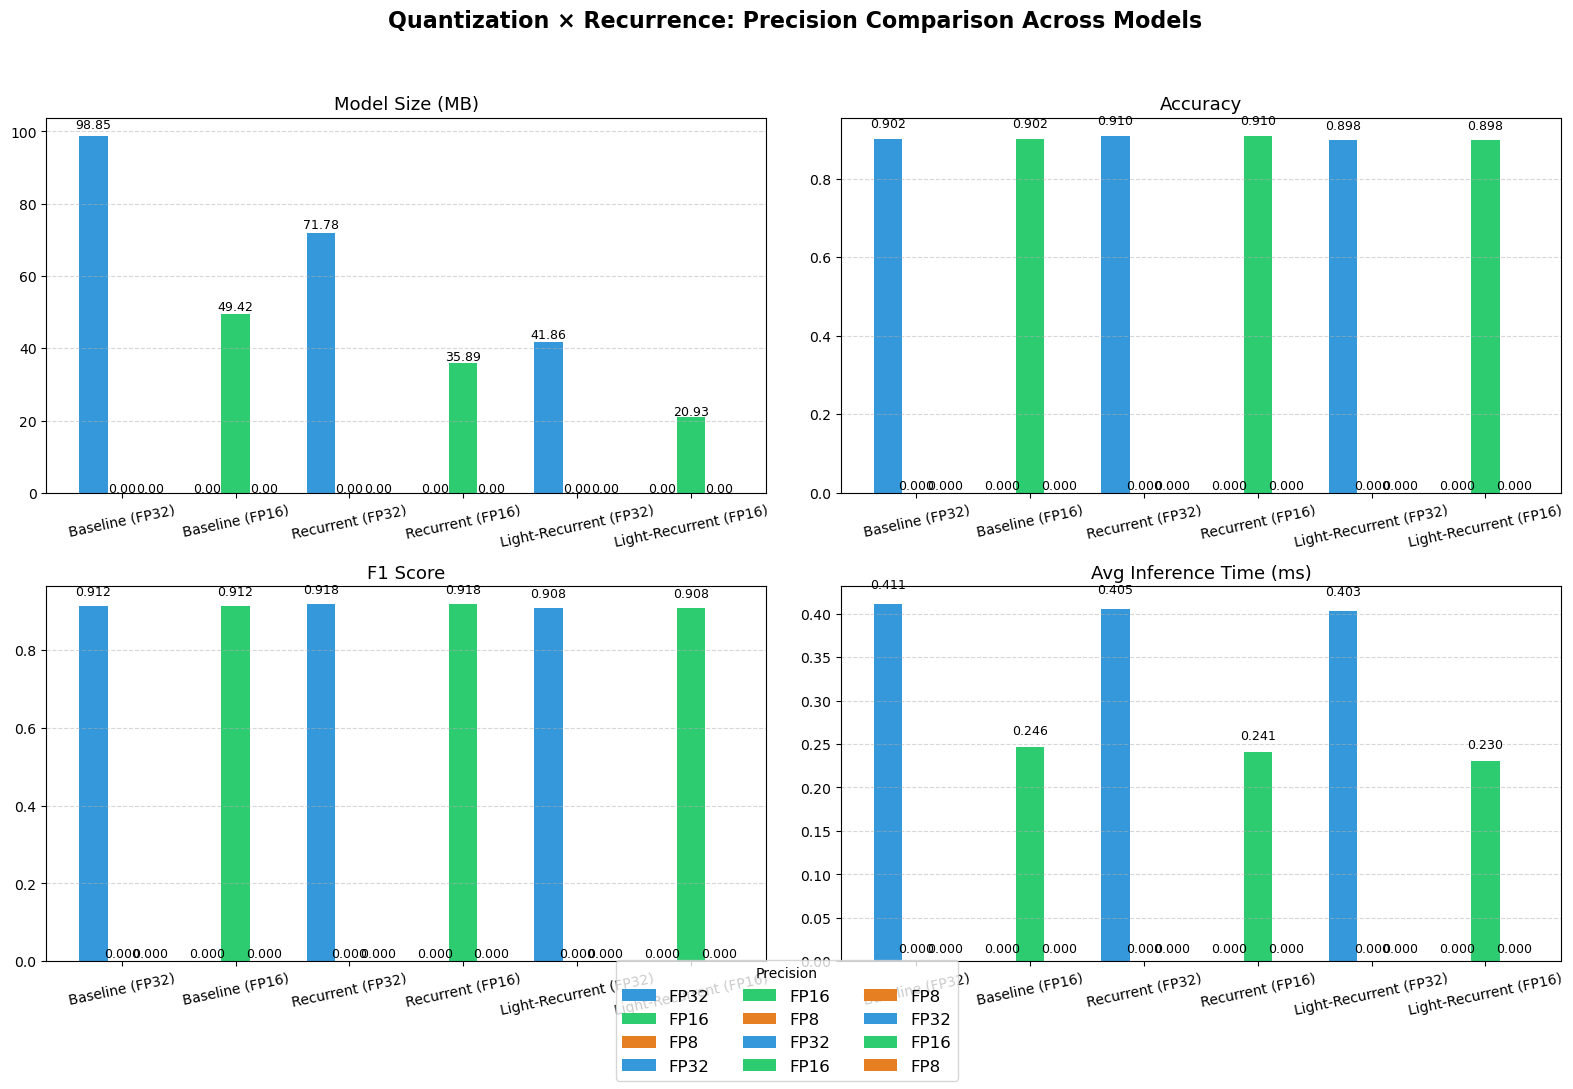

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# -----------------------
# Prepare data
# -----------------------
models = df['model'].unique()
precisions = ["FP32", "FP16", "FP8"]

# Create mapping for grouped bars
x = np.arange(len(models))
width = 0.25

# Colors (consistent across plots)
color_map = {
    "FP32": "#3498db",  # blue
    "FP16": "#2ecc71",  # green
    "FP8":  "#e67e22",  # orange
}

metrics = {
    "Model Size (MB)": "size_mb",
    "Accuracy": "accuracy",
    "F1 Score": "f1",
    "Avg Inference Time (ms)": "avg_inference_ms"
}

# -----------------------
# Create 2×2 subplot
# -----------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 11))
fig.suptitle("Quantization × Recurrence: Precision Comparison Across Models",
             fontsize=16, fontweight="bold")

axes = axes.flatten()

# -----------------------
# Draw each metric subplot
# -----------------------
for ax, (title, col_name) in zip(axes, metrics.items()):

    for i, precision in enumerate(precisions):
        values = []
        for model in models:
            row = df[(df["model"] == model) & (df["precision_type"] == precision)]
            if len(row) == 0:
                values.append(0)
            else:
                values.append(float(row[col_name].values[0]))

        ax.bar(x + i*width - width, values, width,
               label=precision, color=color_map[precision])

    # Labels & formatting
    ax.set_title(title, fontsize=13)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=12)
    ax.grid(axis="y", linestyle="--", alpha=0.5)

    # Add value annotations
    for i, precision in enumerate(precisions):
        values = []
        for model in models:
            row = df[(df["model"] == model) & (df["precision_type"] == precision)]
            values.append(float(row[col_name].values[0]) if len(row) else 0)

        for xi, val in zip(x + i*width - width, values):
            ax.text(xi, val + (val*0.02 + 0.01), f"{val:.3f}" if col_name != "size_mb" else f"{val:.2f}",
                    ha="center", fontsize=9)

# -----------------------
# Legend and save
# -----------------------
fig.legend(title="Precision", loc="lower center", ncol=3, fontsize=12)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()
